# cd into the path where-ever your code is located

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/MachineLearningProject/CrowdedObjectsCounting/HoneyBeesCounting

/content/drive/MyDrive/MachineLearningProject/CrowdedObjectsCounting/HoneyBeesCounting


In [ ]:
!ls

BeesDatasets					 helping_module		     TrainModel
Bees-Dataset-With-Maps-20210210T113744Z-001.zip  label_postprocessing.ipynb  Val.ipynb
BeesVisualisations.ipynb			 making_densitymaps.ipynb
combined_densitymap.ipynb			 PathsToData


# Importing the libararies

In [ ]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy
import scipy.spatial
import json
import torchvision.transforms.functional as F
from helping_module.myimg import *
from helping_module.mymodel import CSRNet
import torch
%matplotlib inline

<ipython-input-4-980916392883>:7: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [ ]:
#from utils import *
from helping_module.mydataset import *

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device='cpu'

In [ ]:
from torchvision import datasets, transforms
trans=transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
                   ])

### Loding the trained model

In [ ]:
model = CSRNet()
model=model.to(device)
#checkpoint_1 = torch.load('TrainedCheckpoints/VAL-20FULL-22model_best.pth.tar',map_location='cpu')
#checkpoint_2 = torch.load('TrainedCheckpoints/VAL-20FULL-6model_best.pth.tar',map_location='cpu')
checkpoint_3 = torch.load('/content/drive/MyDrive/MachineLearningProject/CrowdedObjectsCounting/HoneyBeesCounting/TrainModel/0checkpoint.pth.tar',map_location='cpu')


model.load_state_dict(checkpoint_3['state_dict'])

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 103MB/s] 
<ipython-input-9-b9b358c5c0a4>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to constru

<All keys matched successfully>

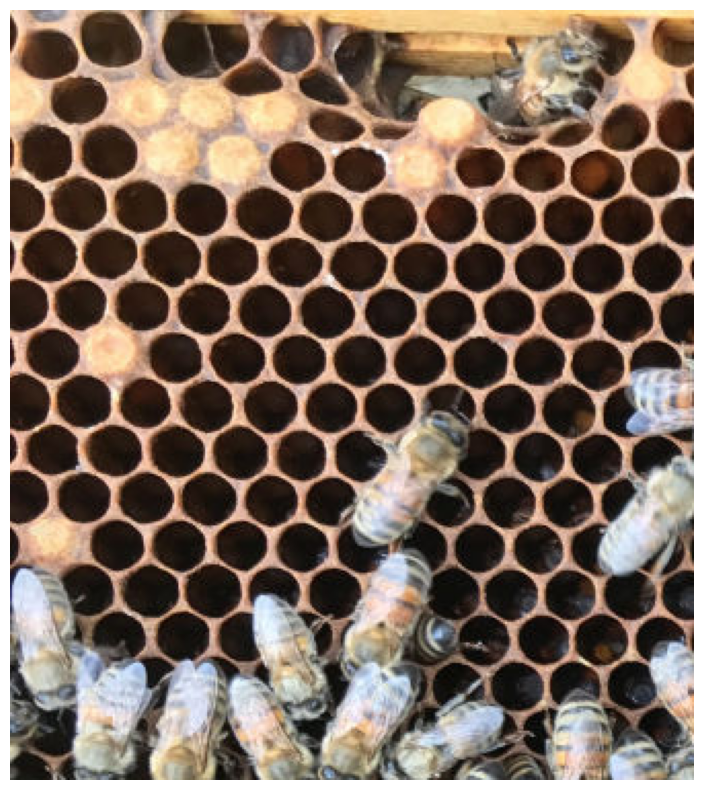

In [ ]:
import warnings
warnings.filterwarnings('ignore')

root = '/content/drive/MyDrive/MachineLearningProject/CrowdedObjectsCounting/HoneyBeesCounting/BeesDatasets/'
img=Image.open(root+'images/1336_01_01.png')
gt=h5py.File(root+'ground-truth-h5/1336_01_01.h5')
gt=np.asarray(gt['density'])
plt.imshow(img)
plt.axis('off')  # Hide axis labels
plt.show()

In [ ]:
img_size=img.size
img_transformed=trans(img)
img_transformed=img_transformed.to(device)
img_output=model(img_transformed.unsqueeze(0))

output_x=torch.nn.functional.interpolate(img_output,size=(img_size[1],img_size[0]))
output_detached=output_x.detach().cpu().numpy()
output_detached=output_detached.squeeze(0).squeeze(0)
clipped_out=np.where(output_detached<0.005,0,output_detached)

<Figure size 1000x1000 with 0 Axes>

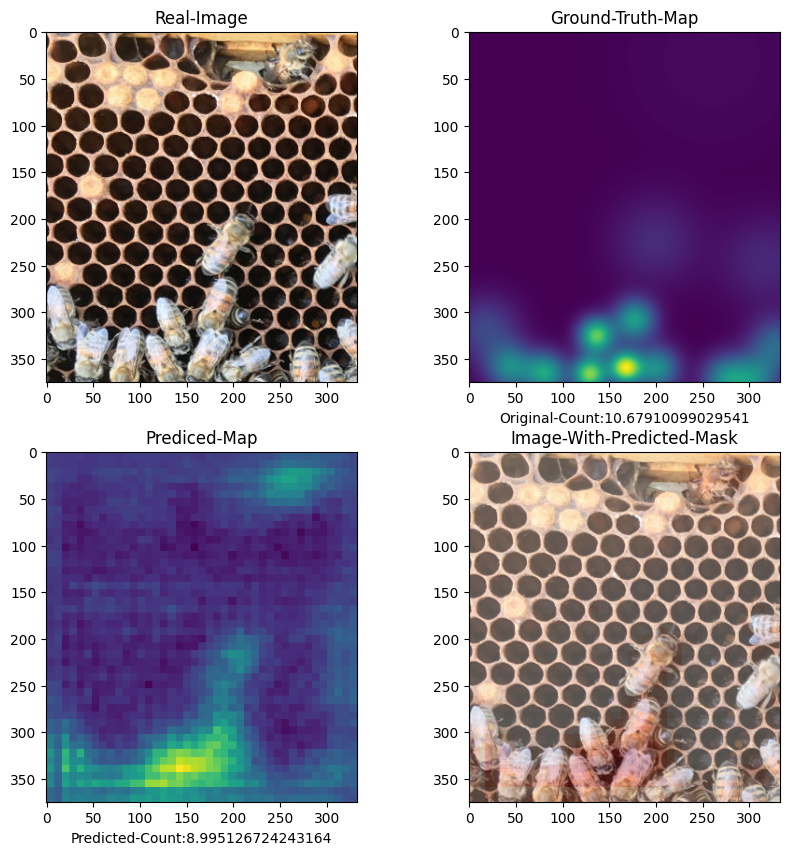

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)

plt.figure(figsize=(10,10),dpi=100)

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,2)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0][0].imshow(img)
axarr[0][0].set_title('Real-Image')
axarr[0][1].imshow(gt)
axarr[0][1].set_title('Ground-Truth-Map')
axarr[0][1].set_xlabel('Original-Count:{}'.format(gt.sum()))


axarr[1][0].imshow(output_detached)
axarr[1][0].set_title('Prediced-Map')
axarr[1][0].set_xlabel('Predicted-Count:{}'.format(img_output.detach().sum()))

axarr[1][1].imshow(img)
axarr[1][1].set_title('Image-With-Predicted-Mask')
axarr[1][1].imshow(clipped_out,cmap='Reds',alpha=0.3)


plt.show()

## If there are no corresponding density-maps as ground-truth

In [ ]:

print(output_detached.max())
print(output_detached.min())
print(output_detached.mean())

0.053785652
-0.0036614414
0.01074781


## **Bees Test Datasets Validation:** MAE, Min and MAX calculation

In [ ]:
import json
import random

# Load data from the .json file
with open("/content/drive/MyDrive/MachineLearningProject/CrowdedObjectsCounting/HoneyBeesCounting/BeesDatasets/bees_val_paths.json", "r") as json_file:
    data = json.load(json_file)

# Access the lists inside the dictionary
img_paths = data#["test_datasets"]


# Print the lists
print("Existing Files:", img_paths)
print(f"Length: {len(img_paths)}")
print(img_paths[random.randint(1, 60)])


Existing Files: ['/content/drive/MyDrive/ColabWork/FurqanWork/BeesWork/CSRNet-270bees/Train270bees/ground-truth-h5/1292_01_01.h5', '/content/drive/MyDrive/ColabWork/FurqanWork/BeesWork/CSRNet-270bees/Train270bees/ground-truth-h5/13443_02_01.h5', '/content/drive/MyDrive/ColabWork/FurqanWork/BeesWork/CSRNet-270bees/Train270bees/ground-truth-h5/13196_01_01.h5', '/content/drive/MyDrive/ColabWork/FurqanWork/BeesWork/CSRNet-270bees/Train270bees/ground-truth-h5/1289_01_02.h5', '/content/drive/MyDrive/ColabWork/FurqanWork/BeesWork/CSRNet-270bees/Train270bees/ground-truth-h5/1285_01_01.h5', '/content/drive/MyDrive/ColabWork/FurqanWork/BeesWork/CSRNet-270bees/Train270bees/ground-truth-h5/1331_01_02.h5', '/content/drive/MyDrive/ColabWork/FurqanWork/BeesWork/CSRNet-270bees/Train270bees/ground-truth-h5/1333_02_02.h5', '/content/drive/MyDrive/ColabWork/FurqanWork/BeesWork/CSRNet-270bees/Train270bees/ground-truth-h5/1347_02_02.h5', '/content/drive/MyDrive/ColabWork/FurqanWork/BeesWork/CSRNet-270bees/

In [ ]:
from tqdm import tqdm


batch_size = 8  # Adjust this based on your GPU memory and image sizes
mae = 0
mse = 0
min_val = float('inf')  # Initialize with a very large value
max_val = -float('inf')  # Initialize with a very small value


num_images = len(img_paths)

# Move the model to GPU if available
#model = model.cuda()


root = '/content/drive/MyDrive/MachineLearningProject/CrowdedObjectsCounting/HoneyBeesCounting/BeesDatasets/test/ground-truth-h5/'
for i in tqdm(range(len(img_paths))):
    file_name = os.path.basename(img_paths[i])
    img_paths[i] = root+ file_name
    img=Image.open(img_paths[i].replace('.h5','.png').replace('ground-truth-h5','images'))
    gt=h5py.File(img_paths[i])
    gt=np.asarray(gt['density'])
    img_size=img.size
    img_transformed=trans(img)
    img_transformed=img_transformed.to(device)
    img_output=model(img_transformed.unsqueeze(0))

    output_x= img_output
    output_detached=output_x.detach().cpu().numpy()
    output_detached=output_detached.squeeze(0).squeeze(0)
    #clipped_out=np.where(output_detached<0.005,0,output_detached)


    # Update MAE
    mae += abs(output_detached.sum() - np.sum(gt))
    mse += abs(output_detached.sum() - np.sum(gt))**2

# Calculate average MAE over all images
average_mae = mae / len(img_paths)
#print(f'Min Value: {min_val}')
#print(f'Max Value: {max_val}')
print(f'MAE: {average_mae}')
print(f'MAE: {mse / len(img_paths)}')


100%|██████████| 60/60 [01:40<00:00,  1.68s/it]

MAE: 2.8640857418378194
MAE: 14.4050159490169


In [ ]:
from tqdm import tqdm


batch_size = 8  # Adjust this based on your GPU memory and image sizes
mae = 0
min_val = float('inf')  # Initialize with a very large value
max_val = -float('inf')  # Initialize with a very small value


num_images = len(img_paths)

# Move the model to GPU if available
#model = model.cuda()


for i in tqdm(range(len(img_paths))):
    img = trans(Image.open(img_paths[i].replace('.h5','.png').replace('ground-truth-h5','images'))).to(device)
    gt_file = h5py.File(img_paths[i],'r')
    groundtruth = np.asarray(gt_file['density'])

    # Ensure the model is on the same device (GPU) as the input image
    output = model(img.unsqueeze(0))

    # Convert the output to a numpy array to work with the groundtruth
    output_np = output.detach().cpu().numpy()

    # Update Min and Max
    min_val = min(min_val, np.min(output_np), np.min(groundtruth))
    max_val = max(max_val, np.max(output_np), np.max(groundtruth))

    # Update MAE
    mae += abs(output_np.sum() - np.sum(groundtruth))

# Calculate average MAE over all images
average_mae = mae / len(img_paths)
print(f'Min Value: {min_val}')
print(f'Max Value: {max_val}')
print(f'MAE: {average_mae}')


100%|██████████| 90/90 [02:27<00:00,  1.64s/it]

Min Value: -0.007791431620717049
Max Value: 0.0685717985033989
MAE: 3.0189148373074


## Error Percentage calculation

In [ ]:
# Given values for Figure A2
actual_value_A2 = 33.25
predicted_value_A2 = 30.37

# Calculate percentage error
percentage_error_A2 = abs(actual_value_A2 - predicted_value_A2) / actual_value_A2 * 100
percentage_error_A2


8.661654135338342